In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import os
import json
import random
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import dtypes
import matplotlib.pyplot as plt

from phaunos_ml.utils.dataset_utils import create_subset, dataset_stat_per_file, read_dataset_file
from phaunos_ml.utils.dataug_utils import tfrecords2dataset_aug, tfrecords2tfdataset, mixup
from phaunos_ml.utils.feature_utils import AudioSegmentExtractor
#from phaunos_ml.utils.dataset_utils import dataset2tfrecords
from phaunos_ml.utils import tf_utils
from phaunos_ml.utils.tf_utils import serialized2data
from nsb_aad.frame_based_detectors.mario_detector import MarioDetector

tf.enable_eager_execution()

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

/home/jul/.miniconda3/envs/phaunos_ml/lib/python3.6/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [3]:
ROOT_PATH = '/home/jul/data/xenocanto/'
LABEL_FILENAME = '/home/jul/data/xenocanto/labels.csv'
SUBSET_PATH = os.path.join(ROOT_PATH, 'custom_subsets')
AUDIO_DIRNAME = 'audio/wav_22050hz_MLR'
ANNOTATION_DIRNAME = 'annotations'

In [5]:
# create Xeno-Canto data subset with 5 randomly picked classes
class_list = sorted([line.strip() for line in open(LABEL_FILENAME, 'r')])
subset_label_set = set(np.random.choice(range(len(class_list)), 2, replace=False))
print(f'Classes: {subset_label_set}')
subset_filename = create_subset(
    ROOT_PATH,
    ['.'],
    SUBSET_PATH,
    audio_dirname=AUDIO_DIRNAME,
    annotation_dirname=ANNOTATION_DIRNAME,
    label_set=subset_label_set)
print(subset_filename)

Classes: {60, 141}
/home/jul/data/xenocanto/custom_subsets/subset_1570008079/subset_1570008079.csv


In [6]:
# Show dataset stats
# Note: The total number of instances might be higher than the number of audio files because a file might have multiple labels
d_num, d_dur = dataset_stat_per_file(ROOT_PATH, subset_filename)
print("Class index, number of files, total duration (in s)") 
for k, v in sorted(d_num.items()): 
    print(f' {k} ({class_list[k]}), {v}, {d_dur[k]:<.3f}')

19it [00:00, 1085.04it/s]

Class index, number of files, total duration (in s)
 60 (ardenna_pacifica), 10, 468.887
 141 (coracias_garrulus), 9, 298.369


In [7]:
# configure activity detector
config_file_mario = '/home/jul/dev/nature_sound_box/nsb_aad/configs/mario.json'
config_mario = json.load(open(config_file_mario, 'r'))
mario_detector = MarioDetector(config_mario)
config_mario

{'sample_rate': 22050,
 'win_length': 512,
 'hop_length': 128,
 'min_freq': 200,
 'max_freq': 11025,
 'clipping_threshold': 3,
 'opening_kernel_shape': [2, 3],
 'median_filter_shape': 10}

In [8]:
# configure audio segment extractor
sr = 22050
segment_dur = 1
segment_hop_dur = 1
audio_ex = AudioSegmentExtractor(sr=sr, example_duration=segment_dur, example_hop_duration=segment_hop_dur)

In [9]:
# generate feature
from phaunos_ml.utils.dataset_utils import dataset2tfrecords
tfrecord_path = os.path.join(os.path.dirname(subset_filename), 'features')
dataset2tfrecords(ROOT_PATH,                  
                  subset_filename,
                  tfrecord_path,
                  feature_extractor=audio_ex,
                  activity_detector=mario_detector,
                  min_activity_dur=0.04,                  
                  audio_dirname=AUDIO_DIRNAME,
                  annotation_dirname=ANNOTATION_DIRNAME
                 )

100%|██████████| 20/20 [00:05<00:00,  2.93it/s]


In [10]:
# check some examples
example_filenames = random.sample(os.listdir(os.path.join(tfrecord_path, 'positive', AUDIO_DIRNAME)), 2)
example1 = tf_utils.tfrecord2example(os.path.join(tfrecord_path, 'positive', AUDIO_DIRNAME, example_filenames[0]), audio_ex)
example2 = tf_utils.tfrecord2example(os.path.join(tfrecord_path, 'positive', AUDIO_DIRNAME, example_filenames[1]), audio_ex)

W1002 11:23:42.366763 140554214725440 deprecation.py:323] From /home/jul/dev/phaunos_ml/phaunos_ml/utils/tf_utils.py:44: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


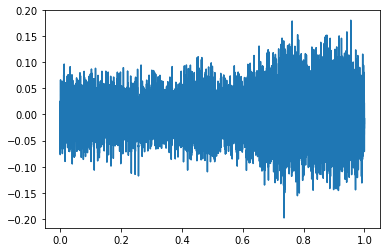

In [11]:
audio_ex.plot(example1[0]['data'][0])

In [12]:
example2

[{'data': <tf.Tensor: id=99, shape=(1, 22050), dtype=float32, numpy=
  array([[-1.5258789e-04,  9.1552734e-04,  1.6479492e-03, ...,
          -1.2881470e-01, -1.6336060e-01, -1.2707520e-01]], dtype=float32)>,
  'filename': <tf.Tensor: id=100, shape=(), dtype=string, numpy=b'audio/wav_22050hz_MLR/XC380944.R.tf'>,
  'labels': <tf.Tensor: id=101, shape=(), dtype=string, numpy=b'141'>,
  'times': <tf.Tensor: id=102, shape=(2,), dtype=float32, numpy=array([0.        , 0.99995464], dtype=float32)>},
 {'data': <tf.Tensor: id=103, shape=(1, 22050), dtype=float32, numpy=
  array([[-0.05209351,  0.02105713,  0.06646729, ..., -0.00491333,
          -0.00845337, -0.00512695]], dtype=float32)>,
  'filename': <tf.Tensor: id=104, shape=(), dtype=string, numpy=b'audio/wav_22050hz_MLR/XC380944.R.tf'>,
  'labels': <tf.Tensor: id=105, shape=(), dtype=string, numpy=b'141'>,
  'times': <tf.Tensor: id=106, shape=(2,), dtype=float32, numpy=array([1.       , 1.9999547], dtype=float32)>},
 {'data': <tf.Tensor:

In [13]:
# get training and augmentation files lists
train_files, train_labels = read_dataset_file(
    subset_filename,
    prepend_path=os.path.join(tfrecord_path, 'positive'),
    replace_ext='.tf')
aug_files, aug_labels = read_dataset_file(
    subset_filename,
    prepend_path=os.path.join(tfrecord_path, 'negative'),
    replace_ext='.tf')

In [15]:
print(f'{train_files[3]}, {train_labels[3]}')

/home/jul/data/xenocanto/custom_subsets/subset_1570008079/features/positive/audio/wav_22050hz_MLR/XC137486.R.tf, {141}


In [17]:
print(f'{aug_files[5]}, {aug_labels[5]}')

/home/jul/data/xenocanto/custom_subsets/subset_1570008079/features/negative/audio/wav_22050hz_MLR/XC303133.M.tf, {60}


In [18]:
class_list = sorted(list(set.union(*train_labels)))
class_list

[60, 141]

In [36]:
# map to dataset
tf_train_files = tf.convert_to_tensor(train_files, dtype=dtypes.string)

In [37]:
tf_train_files = tf.data.Dataset.from_tensor_slices(tf_train_files)

In [55]:
dataset = tf_train_files.interleave(lambda x: tf.data.TFRecordDataset(x), cycle_length=8)

In [56]:
dataset

<DatasetV1Adapter shapes: (), types: tf.string>

In [57]:
dataset = dataset.map(lambda x: serialized2data(x, audio_ex.feature_shape, class_list, training=False))
dataset

<DatasetV1Adapter shapes: ((1, 1, 22050), (2,), (), (2,)), types: (tf.float32, tf.float32, tf.string, tf.float32)>

In [58]:
dataset_aug = tf.data.TFRecordDataset(aug_files)

In [59]:
dataset_aug

<TFRecordDatasetV1 shapes: (), types: tf.string>

In [60]:
dataset_aug = dataset_aug.map(lambda x: serialized2data(x, audio_ex.feature_shape, class_list, training=True))

In [61]:
dataset = dataset.map(lambda feat, labels: (feat, labels))

TypeError: <lambda>() takes 2 positional arguments but 4 were given

In [47]:
dataset

<DatasetV1Adapter shapes: ((1, 1, 22050), (2,)), types: (tf.float32, tf.float32)>